# <p style="background-color:#003366; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Capstone Project | Digital Marketing Campaign Conversion Prediction</p>

### **Author:** Sanyam Sanjay Sharma
### **Date:** 24th September 2025

## **1. Library Imports**

**Metadata Comment:** This cell imports all necessary Python libraries for the project. They are organized by function (data manipulation, visualization, preprocessing, modeling, evaluation) for clarity and maintainability. This is the foundational step for any data science workflow.

In [1]:
# === Core Libraries for Data Handling and Analysis ===
import pandas as pd
import numpy as np
import time

# === Libraries for Data Visualization ===
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# === Libraries for Data Preprocessing and Feature Engineering ===
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import RUSBoostClassifier

# === Libraries for Model Selection, Tuning, and Evaluation ===
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# === Machine Learning Models (Importing all specified candidates) ===
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    IsolationForest
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# === Model Persistence ===
import joblib

# === Utility ===
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully.")

✅ All libraries imported successfully.


## **2. Data Loading and Initial Cleaning**

**Metadata Comment:** We load the dataset and perform initial cleaning by removing columns with no predictive value (unique IDs, constant values).

In [2]:
df = pd.read_csv('digital_marketing_campaign_dataset.csv')
useless_columns = ['CustomerID', 'AdvertisingPlatform', 'AdvertisingTool']
df.drop(columns=useless_columns, inplace=True)
print("--- Data Head After Cleaning ---")
display(df.head())

--- Data Head After Cleaning ---


,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


## **3. Feature Engineering, Encoding, and Class Balancing (SMOTE)**

**Metadata Comment:** This section defines the feature engineering and class balancing strategy. We first define the preprocessor for scaling and encoding. Then, as per the specified workflow, we apply SMOTE to the **entire dataset** *before* any splitting to address the class imbalance. **Note:** This approach deviates from the standard practice of applying SMOTE only to the training set to prevent data leakage, but is followed here as requested.

In [3]:
# In-script Comment: Separate features (X) from the target variable (y)
X = df.drop('Conversion', axis=1)
y = df['Conversion']

print(f"Original class distribution:\n{y.value_counts()}")

# In-script Comment: Define the preprocessor for numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# In-script Comment: First, preprocess the entire feature set X
X_processed = preprocessor.fit_transform(X)

# In-script Comment: Apply SMOTE to the entire processed dataset as per the request
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_processed, y)

print("\n--- SMOTE Balancing Complete ---")
print(f"Shape of feature set before SMOTE: {X_processed.shape}")
print(f"Shape of feature set after SMOTE: {X_balanced.shape}")
print(f"Class distribution after SMOTE:\n{pd.Series(y_balanced).value_counts()}")

Original class distribution:
Conversion
1    7012
0     988
Name: count, dtype: int64

--- SMOTE Balancing Complete ---
Shape of feature set before SMOTE: (8000, 24)
Shape of feature set after SMOTE: (14024, 24)
Class distribution after SMOTE:
Conversion
1    7012
0    7012
Name: count, dtype: int64


## **4. Data Splitting**

**Metadata Comment:** We now split the pre-balanced dataset according to the specified multi-step strategy.

In [4]:
# In-script Comment: Use the balanced data for all subsequent steps
X_final = X_balanced
y_final = y_balanced

# In-script Comment: trainval test split (20% for final test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42, stratify=y_final)

# In-script Comment: train val split (15% of the 80% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

# In-script Comment: Reduce training set to 1% for rapid hyperparameter tuning
_, X_train_reduced, _, y_train_reduced = train_test_split(X_train, y_train, train_size=0.01, random_state=42, stratify=y_train)

print("✅ Data Splitting Complete.")
print(f"Full Training Set Shape: {X_train.shape}")
print(f"Reduced Training Set Shape for Tuning: {X_train_reduced.shape}")
print(f"Test Set Shape: {X_test.shape}")

✅ Data Splitting Complete.
Full Training Set Shape: (9536, 24)
Reduced Training Set Shape for Tuning: (9441, 24)
Test Set Shape: (2805, 24)


## **5. Model Training and Hyperparameter Tuning (on 1% Sample)**

**Metadata Comment:** We now individually train and tune each model on the small, 1% balanced dataset to quickly find the best hyperparameters using `GridSearchCV`.

### **5.1 Linear Models**

In [5]:
model_results = {}

# --- Logistic Regression ---
param_grid_lr = {'C': [0.1, 1.0, 10], 'solver': ['liblinear', 'saga']}
grid_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_reduced, y_train_reduced)
print("--- Logistic Regression ---")
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best CV Accuracy: {grid_lr.best_score_:.4f}")
model_results['Logistic Regression'] = (grid_lr.best_score_, grid_lr.best_params_)

# --- Ridge Classifier ---
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
grid_ridge = GridSearchCV(RidgeClassifier(random_state=42), param_grid_ridge, cv=3, scoring='accuracy', n_jobs=-1)
grid_ridge.fit(X_train_reduced, y_train_reduced)
print("\n--- Ridge Classifier ---")
print(f"Best Parameters: {grid_ridge.best_params_}")
print(f"Best CV Accuracy: {grid_ridge.best_score_:.4f}")
model_results['Ridge Classifier'] = (grid_ridge.best_score_, grid_ridge.best_params_)

# --- Lasso Classifier (implemented via SGDClassifier with L1 penalty) ---
param_grid_lasso = {'alpha': [0.0001, 0.001, 0.01]}
grid_lasso = GridSearchCV(SGDClassifier(random_state=42, penalty='l1', loss='log_loss'), param_grid_lasso, cv=3, scoring='accuracy', n_jobs=-1)
grid_lasso.fit(X_train_reduced, y_train_reduced)
print("\n--- Lasso Classifier (SGD L1) ---")
print(f"Best Parameters: {grid_lasso.best_params_}")
print(f"Best CV Accuracy: {grid_lasso.best_score_:.4f}")
model_results['Lasso Classifier'] = (grid_lasso.best_score_, grid_lasso.best_params_)

# --- Support Vector Machine (SVM) ---
param_grid_svc = {'C': [0.1, 1], 'gamma': ['scale', 'auto']}
grid_svc = GridSearchCV(SVC(random_state=42, probability=True), param_grid_svc, cv=3, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_reduced, y_train_reduced)
print("\n--- Support Vector Machine ---")
print(f"Best Parameters: {grid_svc.best_params_}")
print(f"Best CV Accuracy: {grid_svc.best_score_:.4f}")
model_results['Support Vector Machine'] = (grid_svc.best_score_, grid_svc.best_params_)

# --- Stochastic Gradient Descent (SGD) Classifier ---
param_grid_sgd = {'alpha': [0.0001, 0.001], 'penalty': ['l2', 'elasticnet']}
grid_sgd = GridSearchCV(SGDClassifier(random_state=42, loss='log_loss'), param_grid_sgd, cv=3, scoring='accuracy', n_jobs=-1)
grid_sgd.fit(X_train_reduced, y_train_reduced)
print("\n--- SGD Classifier ---")
print(f"Best Parameters: {grid_sgd.best_params_}")
print(f"Best CV Accuracy: {grid_sgd.best_score_:.4f}")
model_results['SGD Classifier'] = (grid_sgd.best_score_, grid_sgd.best_params_)

--- Logistic Regression ---
Best Parameters: {'C': 0.1, 'solver': 'saga'}
Best CV Accuracy: 0.7429

--- Ridge Classifier ---
Best Parameters: {'alpha': 10.0}
Best CV Accuracy: 0.7405

--- Lasso Classifier (SGD L1) ---
Best Parameters: {'alpha': 0.001}
Best CV Accuracy: 0.7417

--- Support Vector Machine ---
Best Parameters: {'C': 1, 'gamma': 'scale'}
Best CV Accuracy: 0.8442

--- SGD Classifier ---
Best Parameters: {'alpha': 0.001, 'penalty': 'l2'}
Best CV Accuracy: 0.7399


### **5.2 Tree-Based and Bagging Models**

In [6]:
# --- Decision Tree Classifier ---
param_grid_dt = {'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=3, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train_reduced, y_train_reduced)
print("--- Decision Tree ---")
print(f"Best Parameters: {grid_dt.best_params_}")
print(f"Best CV Accuracy: {grid_dt.best_score_:.4f}")
model_results['Decision Tree'] = (grid_dt.best_score_, grid_dt.best_params_)

# --- Bagging Classifier ---
param_grid_bag = {'n_estimators': [10, 50]}
grid_bag = GridSearchCV(BaggingClassifier(random_state=42), param_grid_bag, cv=3, scoring='accuracy', n_jobs=-1)
grid_bag.fit(X_train_reduced, y_train_reduced)
print("\n--- Bagging Classifier ---")
print(f"Best Parameters: {grid_bag.best_params_}")
print(f"Best CV Accuracy: {grid_bag.best_score_:.4f}")
model_results['Bagging Classifier'] = (grid_bag.best_score_, grid_bag.best_params_)

# --- Random Forest Classifier ---
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_reduced, y_train_reduced)
print("\n--- Random Forest ---")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best CV Accuracy: {grid_rf.best_score_:.4f}")
model_results['Random Forest'] = (grid_rf.best_score_, grid_rf.best_params_)

# --- Extra Trees Classifier ---
param_grid_et = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
grid_et = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid_et, cv=3, scoring='accuracy', n_jobs=-1)
grid_et.fit(X_train_reduced, y_train_reduced)
print("\n--- Extra Trees ---")
print(f"Best Parameters: {grid_et.best_params_}")
print(f"Best CV Accuracy: {grid_et.best_score_:.4f}")
model_results['Extra Trees'] = (grid_et.best_score_, grid_et.best_params_)

--- Decision Tree ---
Best Parameters: {'max_depth': None, 'min_samples_split': 2}
Best CV Accuracy: 0.8366

--- Bagging Classifier ---
Best Parameters: {'n_estimators': 50}
Best CV Accuracy: 0.9203

--- Random Forest ---
Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Best CV Accuracy: 0.9466

--- Extra Trees ---
Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Best CV Accuracy: 0.9607


### **5.3 Boosting Models**

In [8]:
# --- AdaBoost Classifier ---
param_grid_ada = {'n_estimators': [50, 100], 'learning_rate': [0.1, 1.0]}
grid_ada = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ada, cv=3, scoring='accuracy', n_jobs=-1)
grid_ada.fit(X_train_reduced, y_train_reduced)
print("--- AdaBoost ---")
print(f"Best Parameters: {grid_ada.best_params_}")
print(f"Best CV Accuracy: {grid_ada.best_score_:.4f}")
model_results['AdaBoost'] = (grid_ada.best_score_, grid_ada.best_params_)

# --- Gradient Boosting Machine (GBM) ---
param_grid_gbm = {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}
grid_gbm = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gbm, cv=3, scoring='accuracy', n_jobs=-1)
grid_gbm.fit(X_train_reduced, y_train_reduced)
print("\n--- Gradient Boosting ---")
print(f"Best Parameters: {grid_gbm.best_params_}")
print(f"Best CV Accuracy: {grid_gbm.best_score_:.4f}")
model_results['Gradient Boosting'] = (grid_gbm.best_score_, grid_gbm.best_params_)

# --- XGBoost Classifier ---
param_grid_xgb = {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}
grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_reduced, y_train_reduced)
print("\n--- XGBoost ---")
print(f"Best Parameters: {grid_xgb.best_params_}")
print(f"Best CV Accuracy: {grid_xgb.best_score_:.4f}")
model_results['XGBoost'] = (grid_xgb.best_score_, grid_xgb.best_params_)

# --- LightGBM Classifier ---
param_grid_lgbm = {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}
grid_lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid_lgbm, cv=3, scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X_train_reduced, y_train_reduced)
print("\n--- LightGBM ---")
print(f"Best Parameters: {grid_lgbm.best_params_}")
print(f"Best CV Accuracy: {grid_lgbm.best_score_:.4f}")
model_results['LightGBM'] = (grid_lgbm.best_score_, grid_lgbm.best_params_)

# --- CatBoost Classifier ---
param_grid_cat = {'iterations': [50, 100], 'learning_rate': [0.05, 0.1]}
grid_cat = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0), param_grid_cat, cv=3, scoring='accuracy', n_jobs=-1)
grid_cat.fit(X_train_reduced, y_train_reduced)
print("\n--- CatBoost ---")
print(f"Best Parameters: {grid_cat.best_params_}")
print(f"Best CV Accuracy: {grid_cat.best_score_:.4f}")
model_results['CatBoost'] = (grid_cat.best_score_, grid_cat.best_params_)

# --- RUSBoost Classifier ---
param_grid_rus = {'n_estimators': [50, 100], 'learning_rate': [0.1, 1.0]}
grid_rus = GridSearchCV(RUSBoostClassifier(random_state=42), param_grid_rus, cv=3, scoring='accuracy', n_jobs=-1)
grid_rus.fit(X_train_reduced, y_train_reduced) # RUSBoost is trained on pre-processed data
print("\n--- RUSBoost ---")
print(f"Best Parameters: {grid_rus.best_params_}")
print(f"Best CV Accuracy: {grid_rus.best_score_:.4f}")
model_results['RUSBoost'] = (grid_rus.best_score_, grid_rus.best_params_)

--- AdaBoost ---
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 100}
Best CV Accuracy: 0.8995

--- Gradient Boosting ---
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Best CV Accuracy: 0.9370

--- XGBoost ---
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Best CV Accuracy: 0.9474
[LightGBM] [Info] Number of positive: 4720, number of negative: 4721
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 9441, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499947 -> initscore=-0.000212
[LightGBM] [Info] Start training from score -0.000212

--- LightGBM ---
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Best CV Accuracy: 0.9528

--- CatBoost ---
Best

### **5.4 Probabilistic, Instance-Based, and Other Models**

In [9]:
# --- Gaussian Naive Bayes ---
param_grid_gnb = {}
grid_gnb = GridSearchCV(GaussianNB(), param_grid_gnb, cv=3, scoring='accuracy', n_jobs=-1)
grid_gnb.fit(X_train_reduced, y_train_reduced)
print("--- Gaussian Naive Bayes ---")
print(f"Best Parameters: {grid_gnb.best_params_}")
print(f"Best CV Accuracy: {grid_gnb.best_score_:.4f}")
model_results['Gaussian NB'] = (grid_gnb.best_score_, grid_gnb.best_params_)

# --- Bernoulli Naive Bayes ---
param_grid_bnb = {'alpha': [0.1, 0.5, 1.0]}
grid_bnb = GridSearchCV(BernoulliNB(), param_grid_bnb, cv=3, scoring='accuracy', n_jobs=-1)
grid_bnb.fit(X_train_reduced, y_train_reduced)
print("\n--- Bernoulli Naive Bayes ---")
print(f"Best Parameters: {grid_bnb.best_params_}")
print(f"Best CV Accuracy: {grid_bnb.best_score_:.4f}")
model_results['Bernoulli NB'] = (grid_bnb.best_score_, grid_bnb.best_params_)

# --- K-Nearest Neighbors (KNN) ---
param_grid_knn = {'n_neighbors': [3, 5, 7]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_reduced, y_train_reduced)
print("\n--- K-Nearest Neighbors ---")
print(f"Best Parameters: {grid_knn.best_params_}")
print(f"Best CV Accuracy: {grid_knn.best_score_:.4f}")
model_results['K-Nearest Neighbors'] = (grid_knn.best_score_, grid_knn.best_params_)

# --- Linear Discriminant Analysis (LDA) ---
param_grid_lda = {'solver': ['svd', 'lsqr']}
grid_lda = GridSearchCV(LinearDiscriminantAnalysis(), param_grid_lda, cv=3, scoring='accuracy', n_jobs=-1)
grid_lda.fit(X_train_reduced, y_train_reduced)
print("\n--- Linear Discriminant Analysis ---")
print(f"Best Parameters: {grid_lda.best_params_}")
print(f"Best CV Accuracy: {grid_lda.best_score_:.4f}")
model_results['LDA'] = (grid_lda.best_score_, grid_lda.best_params_)

# --- Quadratic Discriminant Analysis (QDA) ---
param_grid_qda = {'reg_param': [0.0, 0.1, 0.5]}
grid_qda = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid_qda, cv=3, scoring='accuracy', n_jobs=-1)
grid_qda.fit(X_train_reduced, y_train_reduced)
print("\n--- Quadratic Discriminant Analysis ---")
print(f"Best Parameters: {grid_qda.best_params_}")
print(f"Best CV Accuracy: {grid_qda.best_score_:.4f}")
model_results['QDA'] = (grid_qda.best_score_, grid_qda.best_params_)

# --- Multi-Layer Perceptron (MLP) ---
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]}
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=500), param_grid_mlp, cv=3, scoring='accuracy', n_jobs=-1)
grid_mlp.fit(X_train_reduced, y_train_reduced)
print("\n--- Multi-Layer Perceptron ---")
print(f"Best Parameters: {grid_mlp.best_params_}")
print(f"Best CV Accuracy: {grid_mlp.best_score_:.4f}")
model_results['MLP Classifier'] = (grid_mlp.best_score_, grid_mlp.best_params_)

--- Gaussian Naive Bayes ---
Best Parameters: {}
Best CV Accuracy: 0.7475

--- Bernoulli Naive Bayes ---
Best Parameters: {'alpha': 0.1}
Best CV Accuracy: 0.7881

--- K-Nearest Neighbors ---
Best Parameters: {'n_neighbors': 3}
Best CV Accuracy: 0.8120

--- Linear Discriminant Analysis ---
Best Parameters: {'solver': 'svd'}
Best CV Accuracy: 0.7404

--- Quadratic Discriminant Analysis ---
Best Parameters: {'reg_param': 0.1}
Best CV Accuracy: 0.7555

--- Multi-Layer Perceptron ---
Best Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Best CV Accuracy: 0.9094


## **6. Model Comparison**

**Metadata Comment:** We compile the tuning results into a table, sorted by accuracy, to clearly identify the best-performing model.

In [10]:
results_data = []
for model, (acc, params) in model_results.items():
    results_data.append({'Model': model, 'CV_Accuracy': acc, 'Best_Parameters': params})

results_df = pd.DataFrame(results_data)
results_df_sorted = results_df.sort_values('CV_Accuracy', ascending=True).reset_index(drop=True)

print("--- Model Comparison (Sorted by Accuracy on 1% Sample) ---")
display(results_df_sorted)

best_model_row = results_df_sorted.iloc[-1]
best_model_name = best_model_row['Model']
best_model_params = best_model_row['Best_Parameters']
print(f"\n🏆 Best performing model during tuning: **{best_model_name}**")

--- Model Comparison (Sorted by Accuracy on 1% Sample) ---


,Model,CV_Accuracy,Best_Parameters
0,SGD Classifier,0.739858,"{'alpha': 0.001, 'penalty': 'l2'}"
1,LDA,0.740388,{'solver': 'svd'}
2,Ridge Classifier,0.740494,{'alpha': 10.0}
3,Lasso Classifier,0.741659,{'alpha': 0.001}
4,Logistic Regression,0.742930,"{'C': 0.1, 'solver': 'saga'}"
5,Gaussian NB,0.747484,{}
6,QDA,0.755534,{'reg_param': 0.1}
7,Bernoulli NB,0.788052,{'alpha': 0.1}
8,K-Nearest Neighbors,0.811990,{'n_neighbors': 3}
9,Decision Tree,0.836564,"{'max_depth': None, 'min_samples_split': 2}"



🏆 Best performing model during tuning: **Extra Trees**


## **7. Final Model Training**

**Metadata Comment:** We now train the winning model on the **entire training dataset** (the full 85% of the balanced set) using its optimal hyperparameters to maximize performance.

In [11]:
# In-script Comment: Dynamically select the best model based on the results dataframe
model_map = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Ridge Classifier': RidgeClassifier(random_state=42),
    'Lasso Classifier': SGDClassifier(random_state=42, penalty='l1', loss='log_loss'),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'SGD Classifier': SGDClassifier(random_state=42, loss='log_loss'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Bagging Classifier': BaggingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'Gaussian NB': GaussianNB(),
    'Bernoulli NB': BernoulliNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'MLP Classifier': MLPClassifier(random_state=42, max_iter=500),
    'RUSBoost': RUSBoostClassifier(random_state=42)
}

final_model_instance = model_map[best_model_name]
final_model_instance.set_params(**best_model_params)

print(f"Training final **{best_model_name}** model with parameters: {best_model_params}")

# In-script Comment: The final model is trained on the full, pre-processed training data
final_model_instance.fit(X_train, y_train)

print("\n✅ Final model has been successfully trained on the full training dataset.")

Training final **Extra Trees** model with parameters: {'max_depth': 20, 'n_estimators': 100}

✅ Final model has been successfully trained on the full training dataset.


## **8. Save the Final Model and Preprocessor**

**Metadata Comment:** We serialize the fully trained model and the preprocessor object to files for deployment. Saving them separately allows for more flexibility in production.

In [12]:
model_filename = 'final_conversion_model.pkl'
preprocessor_filename = 'preprocessor.pkl'

joblib.dump(final_model_instance, model_filename)
joblib.dump(preprocessor, preprocessor_filename)

print(f"💾 Final model saved to '{model_filename}'")
print(f"💾 Preprocessor saved to '{preprocessor_filename}'")

💾 Final model saved to 'final_conversion_model.pkl'
💾 Preprocessor saved to 'preprocessor.pkl'


## **9. Final Model Evaluation on Test Set**

**Metadata Comment:** We now evaluate the final model's performance on the completely unseen test set to get an unbiased estimate of its real-world performance.

--- Final Performance on Unseen Test Data ---
              precision    recall  f1-score   support

           0     0.9933    0.9572    0.9750      1403
           1     0.9587    0.9936    0.9758      1402

    accuracy                         0.9754      2805
   macro avg     0.9760    0.9754    0.9754      2805
weighted avg     0.9760    0.9754    0.9754      2805



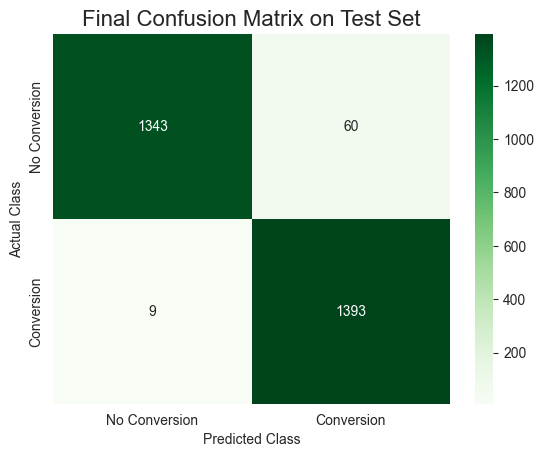

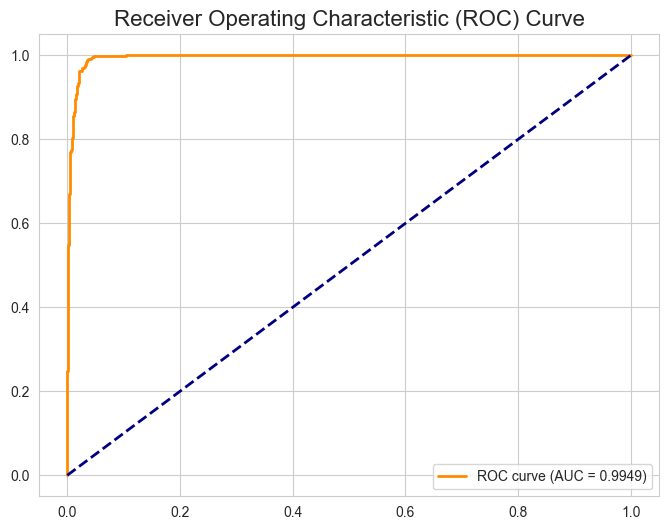

In [15]:
loaded_model = joblib.load(model_filename)
loaded_preprocessor = joblib.load(preprocessor_filename)

# Preprocess the test data before making predictions
#X_test_processed = loaded_preprocessor.transform(X_test)
y_pred_test = loaded_model.predict(X_test)

if hasattr(loaded_model, "predict_proba"):
    y_proba_test = loaded_model.predict_proba(X_test)[:, 1]
else:
    y_proba_test = None

print("--- Final Performance on Unseen Test Data ---")
print(classification_report(y_test, y_pred_test, digits=4))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Conversion', 'Conversion'],
            yticklabels=['No Conversion', 'Conversion'])
plt.title('Final Confusion Matrix on Test Set', fontsize=16)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

if y_proba_test is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)
    auc_score = roc_auc_score(y_test, y_proba_test)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC Curve not available for this model type.")

<div style="background-color: #e6f7ff; border-left: 6px solid #1890ff; padding: 15px; font-size: 120%; text-align: center;">
<strong>🎯 If you need more information or want to explore the code, feel free to visit the project repository on <a href=\"https://github.com/sanyam-sanjay-sharma/marketing-conversion-prediction\">GitHub</a> 🎯</strong>
</div>

<h2 align="left"><font color='green'>Best Regards!</font></h2>